In [8]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import mplfinance as mpf

# Stable-Baselines3 imports
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.vec_env import SubprocVecEnv  # Use this instead of DummyVecEnv

# Gymnasium (updated from Gym)
import gymnasium as gym
from gymnasium import Env
from gymnasium.spaces import Discrete, Box


In [ ]:
# Load Data
df = pd.read_csv("MGOL_data.xml.csv")  # Replace with actual file
df['datetime'] = pd.to_datetime(df['datetime'], format='%m/%d/%y %H:%M')
df.set_index('datetime', inplace=True)

In [15]:
import pandas as pd
import numpy as np
from gym import Env
from gym.spaces import Discrete, Box

# Load Data
df = pd.read_csv("MGOL_data.xml.csv")  # Replace with actual file
df['datetime'] = pd.to_datetime(df['datetime'], format='%m/%d/%y %H:%M')
df.set_index('datetime', inplace=True)

# Custom Trading Environment
class TradingEnv(Env):
    def __init__(self, df):
        super(TradingEnv, self).__init__()
        self.df = df
        self.current_step = 0
        self.balance = 10000  # Starting cash
        self.shares = 0
        self.total_reward = 0

        # Action Space: 0 = Hold, 1 = Buy, 2 = Sell
        self.action_space = Discrete(3)

        # Observation Space: Open, High, Low, Close, Volume
        self.observation_space = Box(
            low=-np.inf, high=np.inf, shape=(5,), dtype=np.float32
        )

    def step(self, action):
        current_price = self.df.iloc[self.current_step]['close']  # Use correct column name
        reward = 0
        done = False
        truncated = False  # Gym v0.26+ requires `truncated` in addition to `done`

        if action == 1:  # Buy
            if self.balance >= current_price:
                self.shares += 1
                self.balance -= current_price
        elif action == 2:  # Sell
            if self.shares > 0:
                self.shares -= 1
                self.balance += current_price
                reward = current_price - self.df.iloc[self.current_step - 1]['close']  # Use correct column name

        self.current_step += 1
        if self.current_step >= len(self.df) - 1:
            done = True  # End of data

        # Get the next observation
        obs = self.df.iloc[self.current_step][['open', 'high', 'low', 'close', 'volume']].values  # Use correct column names
        info = {}  # Additional info (can be used for debugging or logging)

        return obs, reward, done, truncated, info  # Gym v0.26+ requires 5 return values

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)  # Required for Gym v0.26+
        self.current_step = 0
        self.balance = 10000
        self.shares = 0
        observation = self.df.iloc[self.current_step][['open', 'high', 'low', 'close', 'volume']].values  # Use correct column names
        info = {}  # Return an empty info dictionary
        return observation, info

In [16]:
df.index = df.index + pd.Timedelta(hours=3)
df.index.name = 'Date'
df = df.drop(columns=['symbol', 'frame'])
df

,open,high,low,close,volume
Date,,,,,
2025-02-07 04:00:00,0.3106,0.3599,0.3106,0.3386,24030
2025-02-07 04:01:00,0.3386,0.3388,0.3265,0.3265,11337
2025-02-07 04:02:00,0.3290,0.3352,0.3240,0.3288,8203
2025-02-07 04:03:00,0.3251,0.3275,0.3080,0.3123,8875
2025-02-07 04:04:00,0.3124,0.3180,0.3110,0.3124,5318
...,...,...,...,...,...
2025-02-07 19:55:00,0.4299,0.4361,0.4299,0.4349,929
2025-02-07 19:56:00,0.4348,0.4350,0.4300,0.4301,641
2025-02-07 19:57:00,0.4300,0.4350,0.4299,0.4343,1206


In [41]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import DummyVecEnv
import pandas as pd

# Initialize dictionaries to store buy and sell signals
buy_signals_1000 = []
sell_signals_1000 = []
buy_signals_10000 = []
sell_signals_10000 = []
buy_signals_100000 = []
sell_signals_100000 = []

# Initialize the environment and model
env = TradingEnv(df)  # Replace `TradingEnv` with your custom environment
env = DummyVecEnv([lambda: env])  # Wrap the environment for vectorized operations

# Define the PPO model
model = PPO(
    policy="MlpPolicy",  # Policy network
    env=env,             # Environment
    verbose=1,           # Print training logs
    learning_rate=3e-4,  # Learning rate
    n_steps=2048,        # Number of steps per update
    batch_size=64,       # Batch size
    n_epochs=10,         # Number of epochs per update
    gamma=0.99,          # Discount factor
    gae_lambda=0.95,     # GAE parameter
    clip_range=0.2,      # PPO clip range
    ent_coef=0.0,        # Entropy coefficient
    max_grad_norm=0.5,   # Gradient clipping
)

# Save the trained model (optional)
model.save("ppo_model")

# Function to simulate and record buy/sell signals
def simulate_and_record_signals(num_timesteps, buy_signals_list, sell_signals_list):
    # Train the model for the specified number of timesteps
    model.learn(total_timesteps=num_timesteps)

    # Simulate trades
    obs = env.reset()  # Reset the environment
    done = False  # Flag to track if the episode is done

    while not done:
        action, _ = model.predict(obs)  # Predict action (Buy, Sell, or Hold)
        action = action[0]  # Extract the action from the batch (DummyVecEnv)

        # Record buy or sell signals
        current_step = env.get_attr('current_step')[0]  # Get the current step index
        if action == 1:  # Buy signal
            buy_signals_list.append(df.index[current_step])
        elif action == 2:  # Sell signal
            sell_signals_list.append(df.index[current_step])

        # Take action in the environment
        obs, reward, done, info = env.step([action])  # Step through the environment

        # End the episode if done
        if done:
            break

# Run simulation for 1000 timesteps
#simulate_and_record_signals(1000, buy_signals_1000, sell_signals_1000)

# Run simulation for 10000 timesteps
#simulate_and_record_signals(10000, buy_signals_10000, sell_signals_10000)

# Run simulation for 10000 timesteps
simulate_and_record_signals(100000, buy_signals_100000, sell_signals_100000)

# Compare buy and sell signals between 1000 and 10000 timesteps
#print("Buy signals for 1000 timesteps:", buy_signals_1000)
#print("Sell signals for 1000 timesteps:", sell_signals_1000)
#print("\nBuy signals for 10000 timesteps:", buy_signals_10000)
#print("Sell signals for 10000 timesteps:", sell_signals_10000)


/Users/larka/jupyter_env/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cpu device
-----------------------------
| time/              |      |
|    fps             | 2895 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 2611         |
|    iterations           | 2            |
|    time_elapsed         | 1            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0077786115 |
|    clip_fraction        | 0.0767       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.09        |
|    explained_variance   | -0.313       |
|    learning_rate        | 0.0003       |
|    loss                 | -0.00316     |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00377     |
|    value_loss           | 0.00212      |
------------------------------------------

In [43]:
buy_signals_100000

[Timestamp('2025-02-07 04:00:00'),
 Timestamp('2025-02-07 04:02:00'),
 Timestamp('2025-02-07 04:03:00'),
 Timestamp('2025-02-07 04:04:00'),
 Timestamp('2025-02-07 04:05:00'),
 Timestamp('2025-02-07 04:07:00'),
 Timestamp('2025-02-07 04:10:00'),
 Timestamp('2025-02-07 04:11:00'),
 Timestamp('2025-02-07 04:12:00'),
 Timestamp('2025-02-07 04:13:00'),
 Timestamp('2025-02-07 04:14:00'),
 Timestamp('2025-02-07 04:15:00'),
 Timestamp('2025-02-07 04:16:00'),
 Timestamp('2025-02-07 04:17:00'),
 Timestamp('2025-02-07 04:18:00'),
 Timestamp('2025-02-07 04:19:00'),
 Timestamp('2025-02-07 04:20:00'),
 Timestamp('2025-02-07 04:21:00'),
 Timestamp('2025-02-07 04:22:00'),
 Timestamp('2025-02-07 04:23:00'),
 Timestamp('2025-02-07 04:24:00'),
 Timestamp('2025-02-07 04:26:00'),
 Timestamp('2025-02-07 04:28:00'),
 Timestamp('2025-02-07 04:29:00'),
 Timestamp('2025-02-07 04:30:00'),
 Timestamp('2025-02-07 04:31:00'),
 Timestamp('2025-02-07 04:33:00'),
 Timestamp('2025-02-07 04:35:00'),
 Timestamp('2025-02-

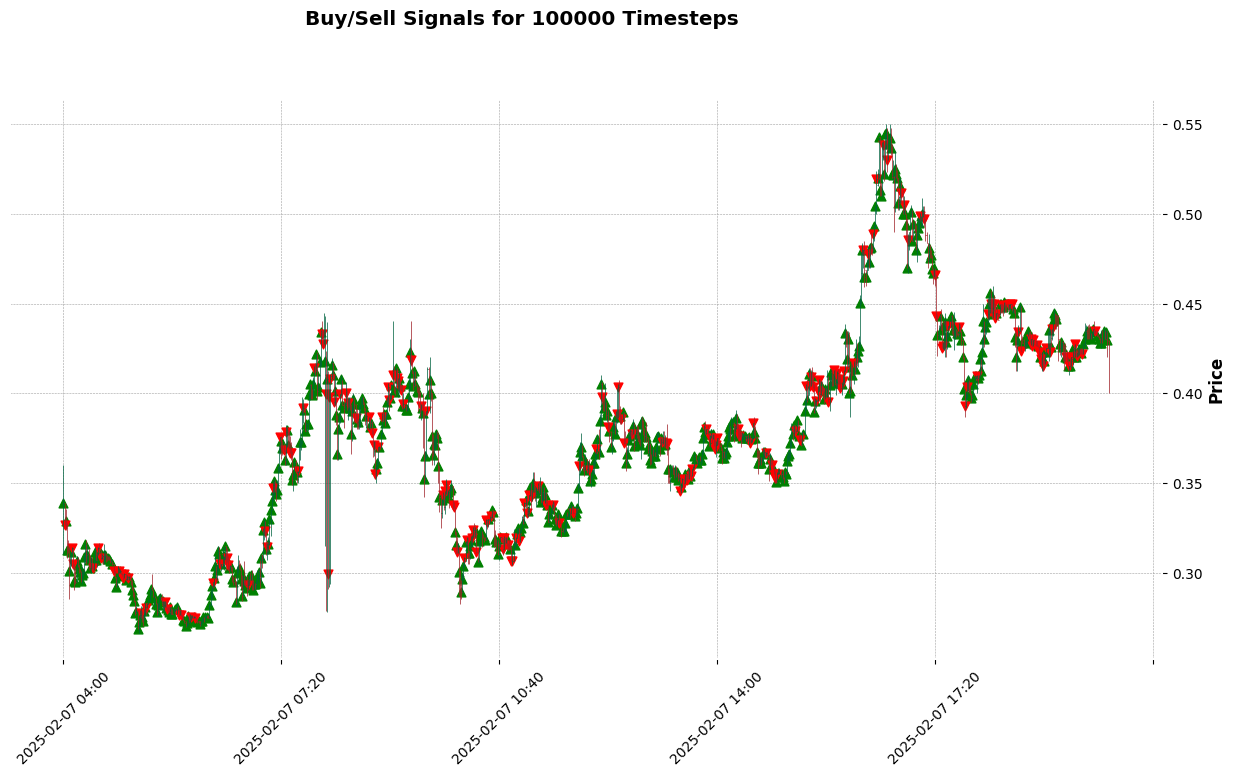

In [46]:
import mplfinance as mpf
import matplotlib.dates as mdates
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your DataFrame, buy_signals_1000, sell_signals_1000, buy_signals_10000, and sell_signals_10000 are your lists of timestamps

# Function to plot the signals for a given buy and sell signal list
def plot_signals(buy_signals, sell_signals, title):
    # Convert buy/sell signals to DatetimeIndex
    buy_signals = pd.to_datetime(buy_signals)  
    buy_signals = buy_signals[buy_signals.isin(df.index)]  # Filter buy signals to match df.index

    sell_signals = pd.to_datetime(sell_signals)  
    sell_signals = sell_signals[sell_signals.isin(df.index)]  # Filter sell signals to match df.index

    # Create new columns to mark the buy and sell signals with NaN for non-signals
    buy_signal_prices = df['close'].copy()
    buy_signal_prices[~df.index.isin(buy_signals)] = float('nan')  # Set non-buy signals to NaN
    
    sell_signal_prices = df['close'].copy()
    sell_signal_prices[~df.index.isin(sell_signals)] = float('nan')  # Set non-sell signals to NaN

    # Create addplots for buy and sell signals
    buy_signal_plot = mpf.make_addplot(buy_signal_prices, type='scatter', markersize=40, marker='^', color='green')
    sell_signal_plot = mpf.make_addplot(sell_signal_prices, type='scatter', markersize=40, marker='v', color='red')

    # Plot with the added buy and sell signals
    fig, axes = mpf.plot(
        df,
        type='ohlc',
        style='charles',
        datetime_format='%Y-%m-%d %H:%M',
        addplot=[buy_signal_plot, sell_signal_plot],
        returnfig=True,
        figsize=(16, 8),
        warn_too_much_data=10000,
        title=title #Adjust the size again to maintain consistency
    )

    #plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

    # Add legend manually
    #plt.legend(['Buy Signals', 'Sell Signals'], loc='upper left')

    # Add title
    #plt.title(title)

    # Show the plot
    #plt.show()

# Plot for 1000 timesteps signals
#plot_signals(buy_signals_1000, sell_signals_1000, title="Buy/Sell Signals for 1000 Timesteps")

# Plot for 10000 timesteps signals
#plot_signals(buy_signals_10000, sell_signals_10000, title="Buy/Sell Signals for 10000 Timesteps")

# Plot for 100000 timesteps signals
plot_signals(buy_signals_100000, sell_signals_100000, title="Buy/Sell Signals for 100000 Timesteps")


Total Profit for Profit for 100000 Timesteps: 11.97
Total Profit for 100000 Timesteps: 11.97


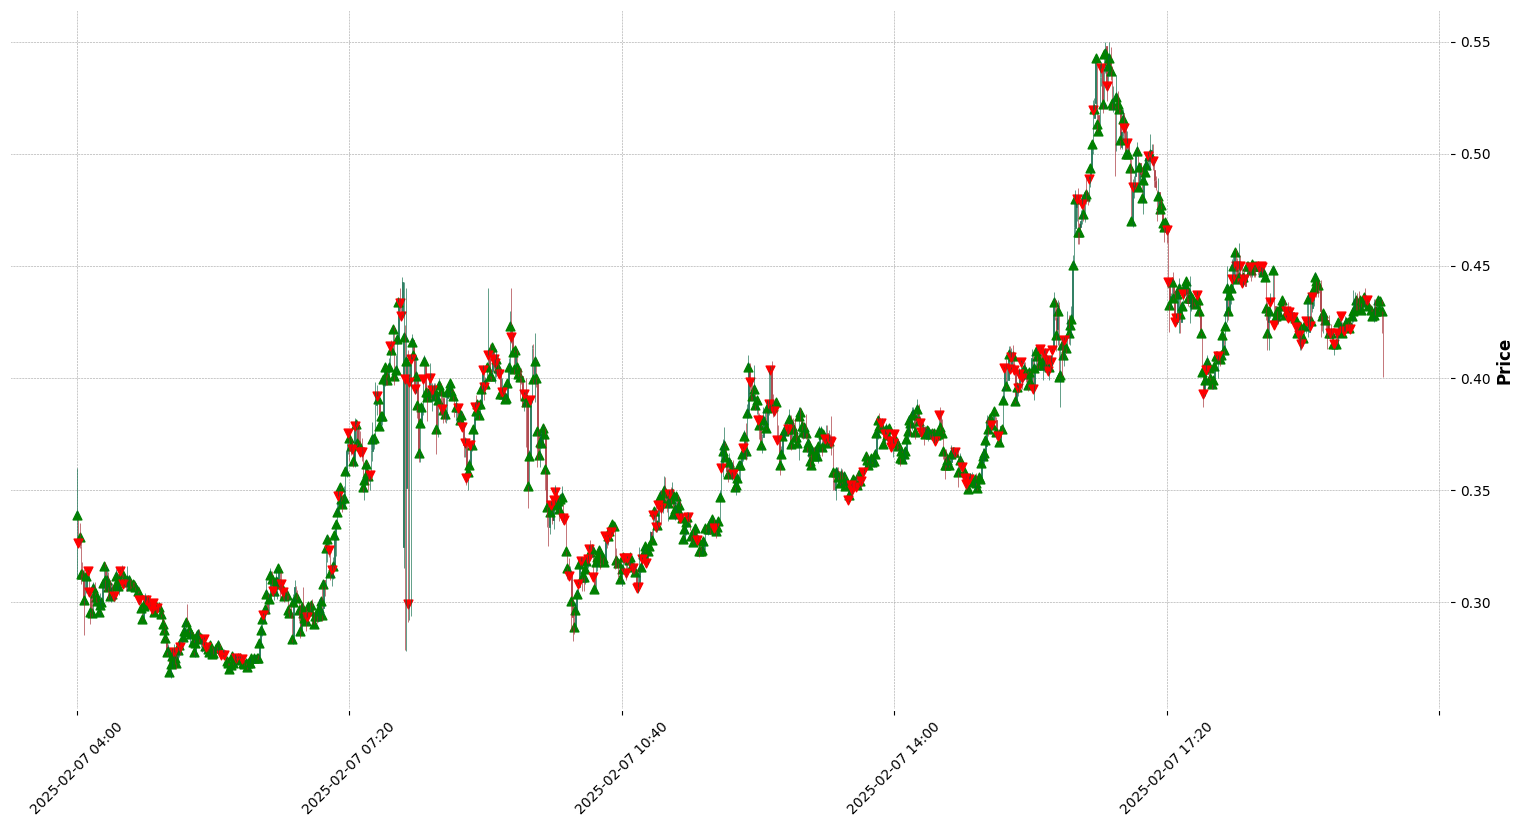

In [48]:
import mplfinance as mpf
import matplotlib.dates as mdates
import pandas as pd
import matplotlib.pyplot as plt

# Function to calculate profit based on buy and sell signals
def calculate_profit(buy_signals, sell_signals, df):
    buy_prices = df.loc[buy_signals, 'close']
    sell_prices = df.loc[sell_signals, 'close']

    # Ensure that the number of buy signals is less than or equal to the number of sell signals
    min_length = min(len(buy_prices), len(sell_prices))

    # Calculate profit for each pair of buy and sell signals
    profits = []
    for i in range(min_length):
        profit = sell_prices.iloc[i] - buy_prices.iloc[i]  # Profit = Sell Price - Buy Price
        profits.append(profit)

    total_profit = sum(profits)
    return total_profit, profits

# Function to plot the signals and compare profits
def plot_signals_and_compare_profit(buy_signals, sell_signals, df, title):
    # Convert buy/sell signals to DatetimeIndex
    buy_signals = pd.to_datetime(buy_signals)  
    buy_signals = buy_signals[buy_signals.isin(df.index)]  # Filter buy signals to match df.index

    sell_signals = pd.to_datetime(sell_signals)  
    sell_signals = sell_signals[sell_signals.isin(df.index)]  # Filter sell signals to match df.index

    # Create new columns to mark the buy and sell signals with NaN for non-signals
    buy_signal_prices = df['close'].copy()
    buy_signal_prices[~df.index.isin(buy_signals)] = float('nan')  # Set non-buy signals to NaN

    sell_signal_prices = df['close'].copy()
    sell_signal_prices[~df.index.isin(sell_signals)] = float('nan')  # Set non-sell signals to NaN

    # Create addplots for buy and sell signals
    buy_signal_plot = mpf.make_addplot(buy_signal_prices, type='scatter', markersize=40, marker='^', color='green')
    sell_signal_plot = mpf.make_addplot(sell_signal_prices, type='scatter', markersize=40, marker='v', color='red')

    # Plot with the added buy and sell signals
    fig, axes = mpf.plot(
        df,
        type='candle',
        style='charles',
        datetime_format='%Y-%m-%d %H:%M',
        addplot=[buy_signal_plot, sell_signal_plot],
        returnfig=True,
        figsize=(20, 10),
        warn_too_much_data=1000  # Adjust the size again to maintain consistency
    )

    # Customize x-axis
    #axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    #plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

    # Add legend manually
    #plt.legend(['Buy Signals', 'Sell Signals'], loc='upper left')

    # Add title
    #plt.title(title)

    # Show the plot
    #plt.show()

    # Calculate and print profit for the signals
    total_profit, profits = calculate_profit(buy_signals, sell_signals, df)
    print(f"Total Profit for {title}: {total_profit:.2f}")
    return total_profit

# Calculate and plot for 1000 timesteps signals
#profit_1000 = plot_signals_and_compare_profit(buy_signals_1000, sell_signals_1000, df, title="Profit for 1000 Timesteps")

# Calculate and plot for 10000 timesteps signals
#profit_10000 = plot_signals_and_compare_profit(buy_signals_10000, sell_signals_10000, df, title="Profit for 10000 Timesteps")

# Calculate and plot for 100000 timesteps signals
profit_100000 = plot_signals_and_compare_profit(buy_signals_100000, sell_signals_100000, df, title="Profit for 100000 Timesteps")


# Compare the total profits
#print(f"Total Profit for 1000 Timesteps: {profit_1000:.2f}")
#print(f"Total Profit for 10000 Timesteps: {profit_10000:.2f}")
print(f"Total Profit for 100000 Timesteps: {profit_100000:.2f}")

In [23]:
df.index

DatetimeIndex(['2025-02-07 04:00:00', '2025-02-07 04:01:00',
               '2025-02-07 04:02:00', '2025-02-07 04:03:00',
               '2025-02-07 04:04:00', '2025-02-07 04:05:00',
               '2025-02-07 04:06:00', '2025-02-07 04:07:00',
               '2025-02-07 04:08:00', '2025-02-07 04:09:00',
               ...
               '2025-02-07 19:50:00', '2025-02-07 19:51:00',
               '2025-02-07 19:52:00', '2025-02-07 19:53:00',
               '2025-02-07 19:54:00', '2025-02-07 19:55:00',
               '2025-02-07 19:56:00', '2025-02-07 19:57:00',
               '2025-02-07 19:58:00', '2025-02-07 19:59:00'],
              dtype='datetime64[ns]', name='Date', length=960, freq=None)